# Port wavelet method spike detection

In [1]:
%load_ext autoreload
import numpy as np 
import os 

import sys
sys.path.append("/home/timsit/mecp2/python/")
import mea_util
import spike_detection as dspikes
import process_spikes as pspikes
import vizpikes 

# Wavelet

import pywt


# plotting 
import matplotlib.pyplot as plt
import sciplotlib.style as splstyle

## Load some data to test that it is running properly

In [2]:
pre_ttx_path = '/home/timsit/mecp2/data/MPT200209_3A_DIV12.mat'
pre_ttx_data = mea_util.hdf_loadmat(pre_ttx_path)

/home/timsit/mecp2/python/mea_util.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(mat_filepath)


## Go through the code (almost line by line) to check the output is the same

In [3]:
# specify the parameters
signal = pre_ttx_data['dat']
SFr = 25 # in Khz
Wid = [0.5, 1.0]
Ns = 2
option = 'c'
L = 0
wname = 'bior1.5'

In [4]:
# Mean subtraction on the signal so that it has zero-mean
signal = signal - np.mean(signal)

In [5]:
Nt = len(signal)  # number of time poinnts

### Determine scales

In [6]:
_signal = np.zeros(shape=(1000))

In [7]:
dt = 1 / SFr

In [8]:
_signal[499] = 1  # create diract function

In [9]:
Width = np.linspace(Wid[0], Wid[1], Ns)

In [10]:
Eps = 10 ** (-15)

In [11]:
ScaleMax = 3
ScaleMax = ScaleMax * SFr

In [12]:
Scales = np.arange(2, ScaleMax+1)

In [15]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

In [16]:
print(wavelet_obj)

NameError: name 'wavelet_obj' is not defined

In [17]:
# c, _ = pywt.cwt(data=_signal, scales=Scales, wavelet='gaus5')
# wavelet_obj = pywt.DiscreteContinuousWavelet('bior1.5')
# wavelet_obj = pywt.ContinuousWavelet('fbsp2-3.0-2.0')
wavelet_obj = pywt.ContinuousWavelet('gaus7')
# c, _ = pywt.cwt(data=_signal, scales=Scales, wavelet=wavelet_obj)

c, _ = pywt.cwt(data=_signal, scales=Scales, wavelet=wavelet_obj)
# c = np.real(c)
# c = np.imag(c)

# c = pywt.swt(data=_signal, wavelet='bior1.5')

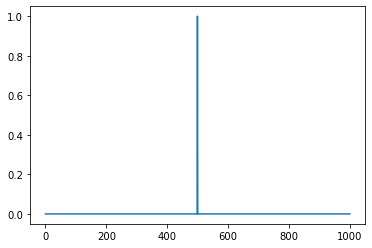

In [18]:
fig, ax = plt.subplots()
ax.plot(_signal)

In [21]:
# load the one computed in matlab 
import scipy.io as sio
c = sio.loadmat('/home/timsit/mecp2/python/notebooks/bior1.5waveletC.mat')['c']

### Can gaus5 replace bior1.5

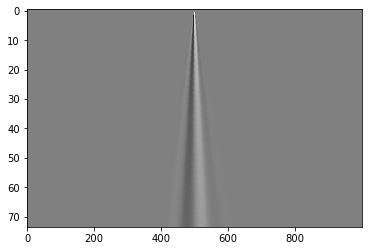

In [20]:
plt.imshow(c, aspect='auto', cmap='gray')

In [21]:
np.min(c)

-0.7110390281291333

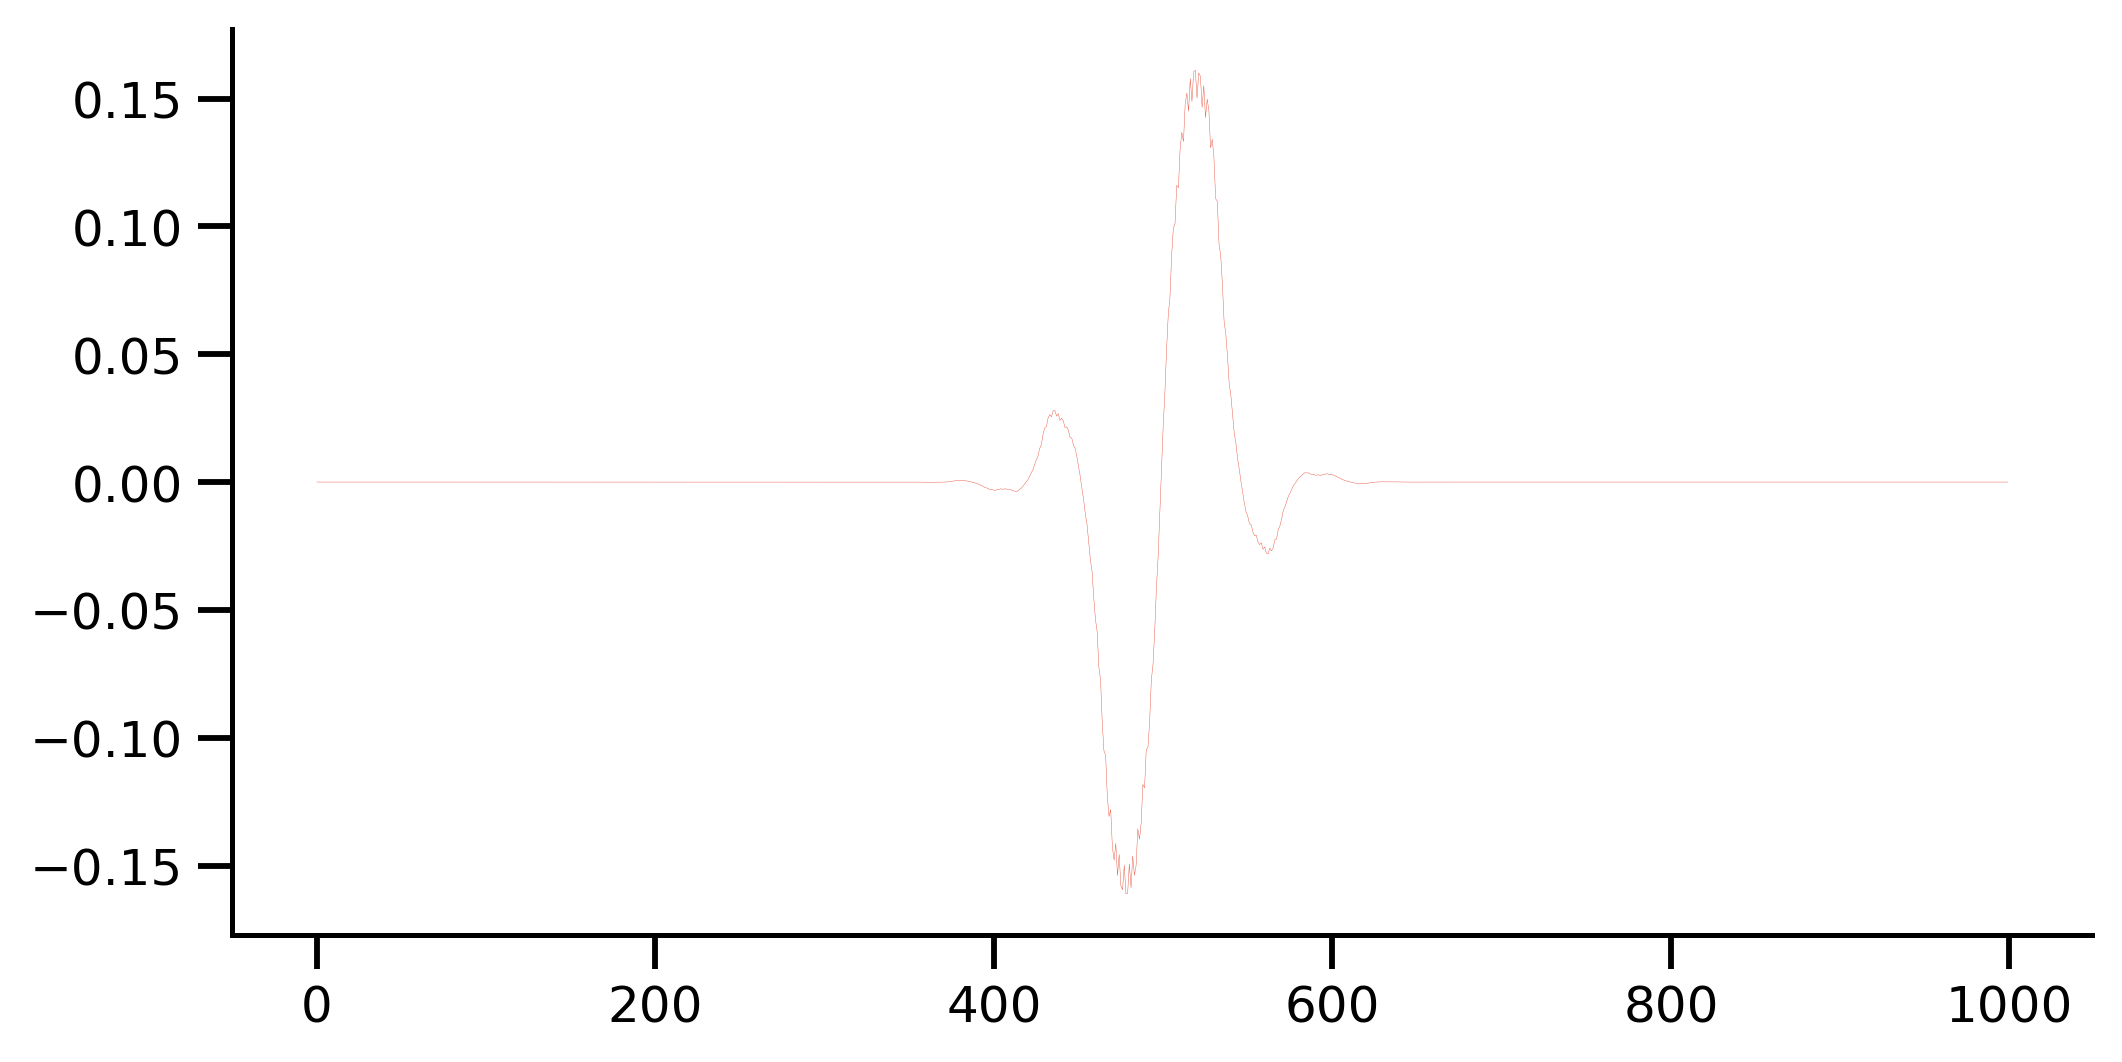

In [22]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)
    ax.plot(np.arange(1000),c[-6, :], linewidth=0.1)

### Iterate through all the wavelets and calculate how similar it is to the bior1.5 from Matlab

In [37]:
candidate_list = ['cgau' + str(derivative) for derivative in np.arange(1, 9)]
candidate_list.extend(['gaus' + str(derivative) for derivative in np.arange(1, 9)])
candidate_list.extend(['mexh', 'morl'])
candidate_list.extend(['cmor1-1', 'cmor0.2-1.1', 'cmor0.2-1.0', 'cmor0.2-0.9', 'cmor0.5-0.8'])

wavelet_output_sim_score_list = list()
for candidate_wavelet in candidate_list: 

    wavelet_obj = pywt.ContinuousWavelet(candidate_wavelet)
    candidate_c, _ = pywt.cwt(data=_signal, scales=Scales, wavelet=wavelet_obj)
    
    if 'cmor' in candidate_wavelet:
        candidate_c = np.imag(candidate_c)
    else:
        candidate_c = np.real(candidate_c)
    
    # difference between filtering result of the candidate wavelet and the biro1.5 wavelet in matlab 
    wavelet_output_sim_score = np.sum((c - candidate_c) ** 2)
    wavelet_output_sim_score_list.append(wavelet_output_sim_score)
    
    

In [38]:
wavelet_output_sim_score_list

[70.40157134612747,
 139.5151067408916,
 213.55241163009046,
 117.23442629060494,
 34.24160410015668,
 138.88258776859576,
 221.5647151614883,
 111.73783151758911,
 99.41821125405548,
 155.80149025660614,
 67.8879877996975,
 151.51352501473093,
 48.95384299535884,
 148.07907350789276,
 37.692025885723254,
 145.45861531088752,
 161.36367062820727,
 136.23279562662023,
 49.60925235241759,
 40.980428898290185,
 33.71198456541317,
 28.2970237705591,
 28.893353775390057]

In [38]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

## What can the Frequency B-spline wavelet look like?

In [25]:
def b_spline_wavelet(t=np.linspace(0, 1000), M=1, B=3, C=0):
    
    psi_t = np.sqrt(B) * ((np.sin(np.pi * B * t / M)) / (np.pi * B * t/M)) ** M * np.exp(2 * np.pi * 1j * C * t)
    
    return psi_t

In [26]:
def cwt_b_spline_wavelet(_signal, Scales, M=1, B=3, C=0):
    
    wavelet_obj = pywt.ContinuousWavelet('fbsp' + str(M) + '-' + str(B) + '-' + str(C))
    
    output_signal, _ = pywt.cwt(data=_signal, scales=Scales, wavelet=wavelet_obj)
    
    return output_signal

/home/timsit/.conda/envs/mecp2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


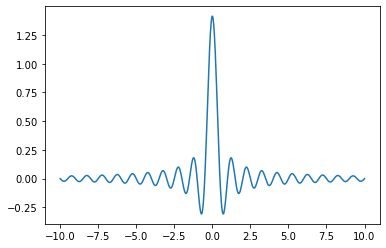

In [27]:
t = np.linspace(-10, 10, 1000)
psi_t = b_spline_wavelet(t=t, M=1, B=2, C=0)
fig, ax = plt.subplots()
ax.plot(t, psi_t)

In [30]:
output_signal = cwt_b_spline_wavelet(_signal=_signal, Scales=Scales, M=1, B=3, C=0)

TypeError: must be real number, not NoneType

In [34]:
M = 3
B = 1.0
C = 1.0
wavelet_obj = pywt.ContinuousWavelet('fbsp' + str(M) + '-' + str(B) + '-' + str(C))
# wavelet_obj = pywt.ContinuousWavelet('fbsp3-1-1')
output_signal, _ = pywt.cwt(data=_signal, scales=Scales, wavelet=wavelet_obj)

In [43]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_bspline_cwt_output(M=3, B=1.0, C=1.0):
    
    wavelet_obj = pywt.ContinuousWavelet('fbsp' + str(M) + '-' + str(B) + '-' + str(C))
    # wavelet_obj = pywt.ContinuousWavelet('fbsp3-1-1')
    output_signal, _ = pywt.cwt(data=_signal, scales=Scales, wavelet=wavelet_obj)
    # output_signal = np.real(output_signal)
    output_signal = np.imag(output_signal)
    with plt.style.context(splstyle.get_style('nature-reviews')):
        plt.figure(2)
        plt.plot(np.arange(1000),c[-6, :], linewidth=1)
        plt.plot(np.arange(1000),output_signal[-6, :], linewidth=0.3)
        plt.show()
    
interactive_plot = interactive(plot_bspline_cwt_output, M=(1, 10), B=1.0, C=1.0)
output = interactive_plot.children[-1]
output.layout.height = '1000px'
interactive_plot

interactive(children=(IntSlider(value=3, description='M', max=10, min=1), FloatSlider(value=1.0, description='…

In [32]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_imaginer_cmor_output(B=1.0, C=1.0):
    
    wavelet_obj = pywt.ContinuousWavelet('cmor' + str(B) + '-' + str(C))
    # wavelet_obj = pywt.ContinuousWavelet('fbsp3-1-1')
    output_signal, _ = pywt.cwt(data=_signal, scales=Scales, wavelet=wavelet_obj)
    output_signal = np.imag(output_signal)
    
    with plt.style.context(splstyle.get_style('nature-reviews')):
        plt.figure(2)
        plt.plot(np.arange(1000),output_signal[-6, :], linewidth=1)
        plt.plot(np.arange(1000),c[-6, :], linewidth=1)
        plt.show()
    
interactive_plot = interactive(plot_imaginer_cmor_output, B=1.0, C=1.0)
output = interactive_plot.children[-1]
output.layout.height = '1000px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='B', max=3.0, min=-1.0), FloatSlider(value=1.0, descr…

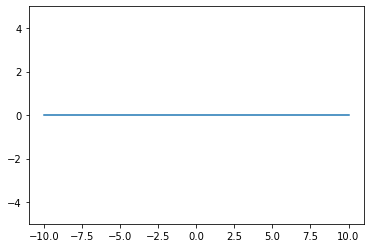

In [48]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [260]:
# try discrete wavelet transform 
# c = pywt.dwt(data=_signal, wavelet=wname)

# Multilevel decomposition using wavedec 
# c =  pywt.wavedec(data=_signal, wavelet=wname)

# Statinary wavelet transform 
# This has the advnatage of not downsapmling the signal
# c =  pywt.swt(data=_signal, wavelet=wname, level=3)

In [261]:
# np.shape(c[2])

In [262]:
# plt.imshow(c[2], aspect='auto', cmap='gray')

In [267]:
Ind = np.empty(shape=2)
WidthTable = np.empty(shape=len(Scales))

for i in np.arange(len(Scales)):
    # indicators of positive coefficients
    IndPos = (c[i, :] > 0).astype(int)
    # indicators of derivative
    IndDer = np.diff(IndPos)
    if wname == 'sym2':
        # indices of positive slope zero crossings
        IndZeroCross = np.where(IndDer == 1)[0]  
    else:
        # indices of negative slope zero crossings
        IndZeroCross = np.where(IndDer == -1)[0] 
    IndMax = (IndZeroCross > 499).astype(int)
    Ind[1] = np.min(IndZeroCross[np.where(IndMax)]) + 1
    IndMin = (IndZeroCross < 499).astype(int)
    Ind[0] = np.max(IndZeroCross[np.where(IndMin)])
    WidthTable[i] = np.diff(Ind) * dt


In [268]:
WidthTable = WidthTable + np.arange(1, len(Scales)+1) * Eps

# Loop-up table
Scale = np.empty(shape=2)
Scale = np.round(np.interp(xp=WidthTable, fp=Scales, x=Width))  # linear interpolation



In [269]:
Scale

array([ 8., 18.])

In [246]:
np.min(IndZeroCross[IndMax])

313

In [248]:
Scale

array([ 8., 18.])

In [242]:
IndZeroCross

array([313, 315, 320, 328, 345, 379, 448, 549, 618, 652, 669, 678, 682,
       684, 686])

## Plotting the wavelet shapes

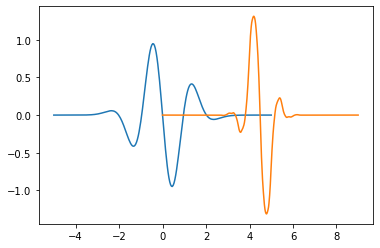

In [142]:
fig, ax = plt.subplots()

wavelet = pywt.ContinuousWavelet('gaus5')
# wavelet_handle = wavelet.wavefun()
wavelet_y, wavelet_x =  wavelet.wavefun()

bior_wavelet = pywt.Wavelet('bior1.5')
bior_output = bior_wavelet.wavefun()
bior_y = bior_output[1]  # quite strange that the first output looks entirely differnt
# why is that, and I can't find this is here either:
# https://uk.mathworks.com/help/wavelet/gs/introduction-to-the-wavelet-families.html
bior_x = bior_output[-1]

ax.plot(wavelet_x, wavelet_y)

ax.plot(bior_x, bior_y)

In [131]:
bior_output[-1]

array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
       8.98828125e+00, 8.99218750e+00, 8.99609375e+00])

## Continuous wavelet transform or discrete wavelet transform?

In [273]:
Scales

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75])

# Try directly calling matlab

In [7]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [285]:
A = matlab.double(_signal.tolist())
c = eng.cwt(A,matlab.double(Scales.tolist()),'bior1.5')

In [4]:
np.shape(signal)

(60, 7500000)

In [10]:
channel_trace.tolist()

[-4006.9557,
 -4003.7811,
 -4000.6065,
 -4000.7286,
 -4003.659,
 -4006.8336,
 -4009.3977,
 -4010.985,
 -4011.9618,
 -4013.5491,
 -4012.9386,
 -4009.0314,
 -4007.322,
 -4008.543,
 -4009.2756,
 -4007.4441,
 -4006.3452,
 -4006.101,
 -4004.2695,
 -4001.5833,
 -4002.5601,
 -4005.6126,
 -4005.9789,
 -4005.7347,
 -4005.3684,
 -4004.3916,
 -4005.8568,
 -4008.4209,
 -4006.101,
 -4001.5833,
 -4000.6065,
 -4002.6822,
 -4004.7579,
 -4005.9789,
 -4006.101,
 -4006.9557,
 -4008.9093,
 -4007.6883,
 -4004.7579,
 -4005.2463,
 -4008.0546,
 -4008.7872,
 -4007.1999,
 -4004.1474,
 -4002.1938,
 -4004.6358,
 -4008.6651,
 -4008.4209,
 -4006.101,
 -4007.0778,
 -4009.0314,
 -4007.6883,
 -4003.7811,
 -4000.4844,
 -3999.0192,
 -3999.0192,
 -3998.5308,
 -3998.1645,
 -3997.7982,
 -3995.112,
 -3993.891,
 -3995.6004,
 -3998.6529,
 -4001.217,
 -4001.4612,
 -3999.6297,
 -3998.775,
 -4000.9728,
 -4004.88,
 -4007.5662,
 -4005.6126,
 -4001.4612,
 -3997.3098,
 -3993.2805,
 -3990.3501,
 -3989.3733,
 -3990.1059,
 -3992.5479,


### Directly call the spike detection script

In [26]:
spike_times = eng.detect_spikes_wavelet(matlab.double(channel_trace.tolist()), 25.0, 
                                       matlab.double([0.5, 1.0]), 2.0,
                                      'c', 0.0, 'bior1.5', 0.0, 0.0)

In [28]:
spike_times = np.asarray(spike_times)

In [29]:
spike_times

array([[1312610., 2748775., 2779793., ..., 7499265., 7499357., 7499944.]])

# Some testing of the wavelets

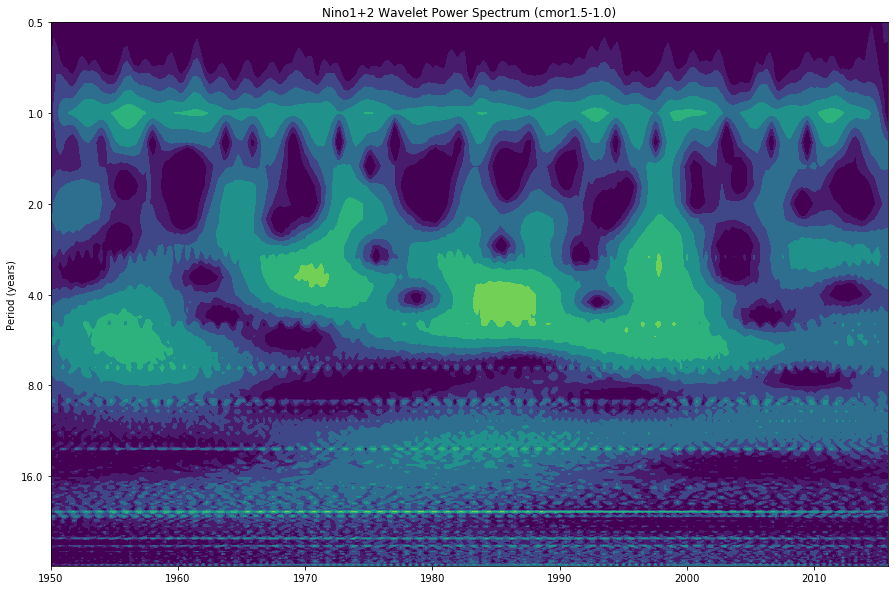

In [53]:
# From: https://github.com/PyWavelets/pywt/blob/580d79d9440ec0f4f936892e39c79ad13a8fd33b/demo/cwt_analysis.py
import numpy as np
import matplotlib.pyplot as plt

import pywt

time, sst = pywt.data.nino()
dt = time[1] - time[0]

# Taken from http://nicolasfauchereau.github.io/climatecode/posts/wavelet-analysis-in-python/
wavelet = 'cmor1.5-1.0'
scales = np.arange(1, 128)

[cfs, frequencies] = pywt.cwt(sst, scales, wavelet, dt)
power = (abs(cfs)) ** 2

period = 1. / frequencies
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
f, ax = plt.subplots(figsize=(15, 10))
ax.contourf(time, np.log2(period), np.log2(power), np.log2(levels),
            extend='both')

ax.set_title('%s Wavelet Power Spectrum (%s)' % ('Nino1+2', wavelet))
ax.set_ylabel('Period (years)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                        np.ceil(np.log2(period.max())))
ax.set_yticks(np.log2(Yticks))
ax.set_yticklabels(Yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1)

plt.show()